In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Get column names and types for the "measurement" table
inspector = inspect(engine)
columns = inspector.get_columns("measurement")
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Find the most recent date in the data set.
recent_date = session.query(measurement).order_by(measurement.date.desc()).first()
recent_date_str = recent_date.date
recent_date_str

'2017-08-23'

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
# Convert the data type from string to date for the most recent date
recent_date_dt = dt.datetime.strptime(recent_date_str, '%Y-%m-%d').date()
# Calculate the date one year from the last date in data set.
year_ago_dt = recent_date_dt - dt.timedelta(days=365)
# Convert the data type from date to string for the date one yearfrom the last date in data set.
year_ago_str = str(year_ago_dt)
year_ago_str

'2016-08-23'

In [12]:
# Perform a query to retrieve the data and precipitation scores
recent_year = session.query(measurement.prcp, measurement.date).\
    filter(measurement.date >= year_ago_str).\
    filter(measurement.date <= recent_date_str).\
    order_by(measurement.date)
recent_year_sql = str(recent_year)

In [13]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.read_sql(recent_year_sql, engine, params=(year_ago_str, recent_date_str))
precipitation_df = precipitation_df.rename(columns={"measurement_prcp": "Precipitation", 
                                                    "measurement_date": "Date"})
# SQL query already sorted by date, here we set the date as the dataframe's index
precipitation_df = precipitation_df.set_index(["Date"])
precipitation_df.head()

Precipitation
Date                     
2016-08-23           0.00
2016-08-23           0.15
2016-08-23           0.05
2016-08-23            NaN
2016-08-23           0.02

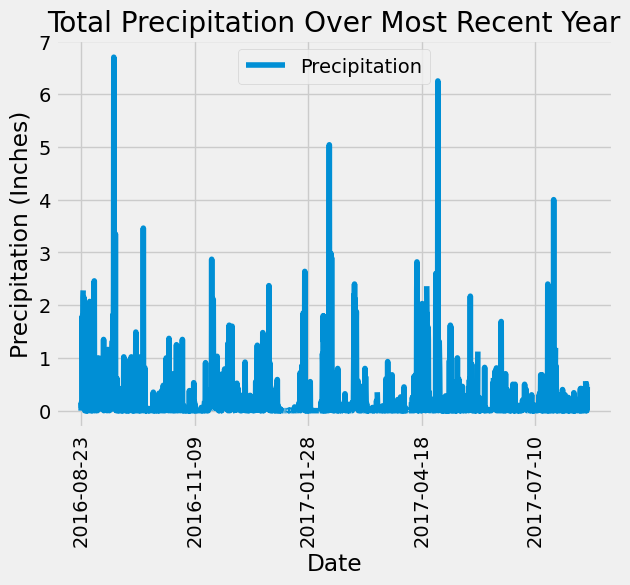

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(rot=90)
plt.xlabel("Date")
plt.ylabel("Precipitation (Inches)")
plt.title("Total Precipitation Over Most Recent Year")
plt.show()

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
# This method gives a summary of each day
prcp_summary = precipitation_df.groupby(["Date"]).agg({"Precipitation":["mean", "median", "var", "std", "sem"]})
prcp_summary

Precipitation                                     
                    mean median       var       std       sem
Date                                                         
2016-08-23      0.451667  0.100  0.499097  0.706468  0.288414
2016-08-24      1.555000  1.800  0.706510  0.840541  0.343150
2016-08-25      0.077143  0.080  0.005157  0.071813  0.027143
2016-08-26      0.016667  0.015  0.000267  0.016330  0.006667
2016-08-27      0.064000  0.020  0.006680  0.081731  0.036551
...                  ...    ...       ...       ...       ...
2017-08-19      0.030000  0.000  0.002700  0.051962  0.030000
2017-08-20      0.005000  0.005  0.000050  0.007071  0.005000
2017-08-21      0.193333  0.020  0.100933  0.317700  0.183424
2017-08-22      0.166667  0.000  0.083333  0.288675  0.166667
2017-08-23      0.132500  0.040  0.046225  0.215000  0.107500

[366 rows x 5 columns]

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
# This method gives a summary of the full year
precipitation_df.describe()

Precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000

# Exploratory Station Analysis

In [17]:
# Get column names and types for the "station" table
inspector = inspect(engine)
columns = inspector.get_columns("station")
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [18]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(station.station)).all()

[(9,)]

In [19]:
session.query(station.name).all()

[('WAIKIKI 717.2, HI US',),
 ('KANEOHE 838.1, HI US',),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US',),
 ('PEARL CITY, HI US',),
 ('UPPER WAHIAWA 874.3, HI US',),
 ('WAIMANALO EXPERIMENTAL FARM, HI US',),
 ('WAIHEE 837.5, HI US',),
 ('HONOLULU OBSERVATORY 702.2, HI US',),
 ('MANOA LYON ARBO 785.2, HI US',)]

In [20]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_activity = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by((func.count(measurement.station)).desc()).\
    all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Find the most active station
most_active = list(np.ravel(station_activity))
most_active = most_active[0]
most_active

'USC00519281'

In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(measurement.tobs), func.max(measurement.tobs),
                                       func.avg(measurement.tobs)).filter(measurement.station == most_active).all()

[(54.0, 85.0, 71.66378066378067)]

In [23]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_query = session.query(measurement.tobs, func.count(measurement.tobs)).\
    filter(measurement.station == most_active).\
    filter(measurement.date >= year_ago_str).\
    filter(measurement.date <= recent_date_str).\
    group_by(measurement.tobs).\
    order_by((func.count(measurement.tobs)).desc())
most_active_station_sql = str(most_active_query)
# Create the dataframe
most_active_station_df = pd.read_sql(most_active_station_sql, engine, params=(most_active, year_ago_str, recent_date_str))
most_active_station_df = most_active_station_df.rename(columns={"measurement_tobs": "Temperature", 
                                                    "count_1": "Frequency"})
most_active_station_df.head()

Temperature  Frequency
0         74.0         39
1         76.0         33
2         75.0         33
3         77.0         31
4         78.0         22

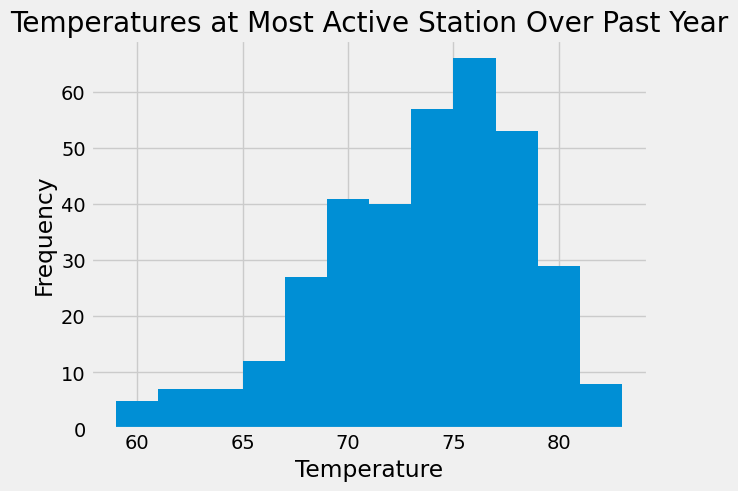

In [24]:
# Plot the dataframe
plt.hist(most_active_station_df.Temperature, weights=most_active_station_df.Frequency, bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Temperatures at Most Active Station Over Past Year")
plt.show()

# Close Session

In [25]:
# Close Session
session.close()